# Neural Network using PyTorch

In this exercise, you will build a neural network using PyTorch, and apply it to a dataset. Our goal in this exercise is not necessarily to obtain the best results on the dataset. We care more about understanding the different parameters, getting a hands-on experience training networks, and monitoring and debugging them. For this reason, I actually recommend that you don’t use a GPU, and run the code on your local machine, for simpler debugging.


You can get relevant code snippets from [the PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) or other sources online. 

## Dataset
We will use the CIFAR-10 dataset.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from torch.utils.tensorboard import SummaryWriter

import tensorboard

%matplotlib inline

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


First, let's get to know the dataset. Plot a few examples of images and their labels:


(50000, 32, 32, 3)
frog
truck
truck
deer
automobile
automobile
bird
horse


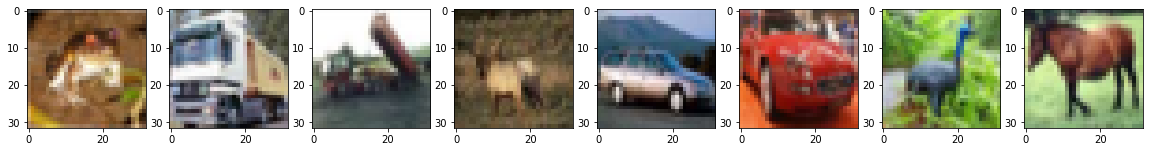

In [3]:
print(trainset.data.shape)
plt.figure(figsize=(20,10))
columns = 8
for i in range(8):
    plt.subplot(8 / columns + 1, columns, i + 1)
    plt.imshow(trainset.data[i])

for i in trainset.targets[0:8]:
    print(trainset.classes[i])


(<matplotlib.axes._subplots.AxesSubplot at 0x7faca6d3a208>,
 <matplotlib.image.AxesImage at 0x7faca6c9f9b0>)

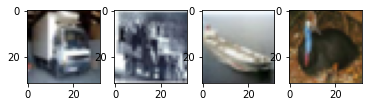

In [4]:
plt.subplot(141), plt.imshow(trainset.data[2001], cmap='gray')
plt.subplot(142), plt.imshow(trainset.data[2002], cmap='gray')
plt.subplot(143), plt.imshow(trainset.data[2003], cmap='gray')
plt.subplot(144), plt.imshow(trainset.data[2004], cmap='gray')

Display the distribution of images per label.

In [6]:
targets = pd.DataFrame({'class':[trainset.classes[trainset.targets[i]] for i in range(len(trainset.targets)) ]})
dir(targets)
targets.expanding()
targets.groupby('class').size()

class
airplane      5000
automobile    5000
bird          5000
cat           5000
deer          5000
dog           5000
frog          5000
horse         5000
ship          5000
truck         5000
dtype: int64

Is the data balanced? What effect is imbalanced data expected to have on your model's results? How can you work with imbalanced data?

### Answer

Yes, the data is balance, 

The unbalanced classes create a problem due to two main reasons:

- We don’t get optimized results for the class which is unbalanced in real time as the model/algorithm never gets sufficient look at the underlying class

- It creates a problem of making a validation or test sample as its difficult to have representation across classes in case number of observation for few classes is extremely less

There are three main approaches to work with imbalanced data, each having its pros and cons:

- Undersampling- Randomly delete the class which has sufficient observations so that the comparative ratio of two classes is significant in our data.Although this approach is really simple to follow but there is a high possibility that the data that we are deleting may contain important information about the predictive class.

- Oversampling-For the unbalanced class randomly increase the number of observations which are just copies of existing samples.This ideally gives us sufficient number of samples to play with.The oversampling may lead to overfitting to the training data

- Synthetic sampling(SMOTE)-The technique asks to synthetically manufacture observations of unbalanced classes which are similar to the existing using nearest neighbors classification.The problem is what to do when the number of observations of is an extremely rare class .For example-we may have only one picture of a rare species which we want to identify using image classification algorithm


**NOTE:** It's a good practice when working on Neural Networks to start with a very small dataset and overfit on it. While we don't specifically ask you to do so in the sections below, we recommend that you take this approach, and first write and run your code using easy to use and debug platform, on a small dataset.

## Build your own CNN classifier
In this section, you will develop your own CNN classifier.

This is meant as an opportunity to get more experience building your own NN architectures using PyTorch, and our focus is on making sure you rewrite and review the needed code and not on obtaining optimal performance. That being said, within the limits of the time you have, try to come up with a NN architecture and hyperparameters that would achieve nice results on the dataset.  
We do recommend that you keep this to only 3-4 Conv layers and 1-2 fully connected layers.

If you want a starting point, you can create this network:

```
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```

When training the network, use the Adam optimizer.

In [12]:
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F

In [18]:

train_x = trainset.data.reshape(50000, 3, 32, 32).astype(np.int32)
train_x  = torch.from_numpy(train_x)

train_y = np.array(trainset.targets);
train_y = torch.from_numpy(train_y)

In [19]:

# converting validation images into torch format
val_x = testset.data.reshape(10000, 3, 32, 32)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = np.array(testset.targets);
val_y = torch.from_numpy(val_y)


In [20]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
        
        Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1)),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        Conv2d(6, 24, kernel_size=(5, 5), stride=(1, 1)),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1),padding=2),
        ReLU(inplace=True),
        Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1),padding=2),
        ReLU(inplace=True),    
        MaxPool2d(kernel_size=2, stride=2),
        )
        self.drop_out = Dropout()
        self.fc1 = Linear(in_features=1200, out_features=120, bias=True)
        self.fc2 = Linear(in_features=120, out_features=84, bias=True)
        self.fc3 = Linear(in_features=84, out_features=10, bias=True)
        self.softmax = Softmax(dim=1)

    # Defining the forward pass    
    def forward(self, input):
      
        output = self.cnn_layers(input)
        output = self.drop_out(output)
       
        output = output.view(output.size(0),  48* 5* 5)
       
        output = self.fc1(output)
        output = F.relu(self.fc2(output))
        output = self.softmax(self.fc3(output))
        return output

In [21]:
#call this model, and define the optimizer and the loss function for the model
# defining the model
model_without_batchnorm = Net()
# defining the optimizer (Adam optimizer)
optimizer = Adam(model_without_batchnorm.parameters(), lr=0.001)
# defining the loss function
criterion = CrossEntropyLoss()

print(model_without_batchnorm)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 24, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [24]:
# Train the model
def train(model, num_epochs = 100, batch_size = 10000):
    loss_list = []
    loss_val_list = []
    acc_list = []
    writer = SummaryWriter()

    model.train()

    items = np.arange(train_x.shape[0])
    items_index = np.random.choice(items, size=batch_size , replace=False)
    x_train, y_train = Variable(train_x), Variable(train_y)

    for epoch in range(num_epochs):

        optimizer.zero_grad()
        # Run the forward pass

        outputs = model.forward(train_x[items_index].float())
        loss = criterion(outputs, train_y[items_index])

        # Backprop and perform Adam optimisation

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        # Track the accuracy
        total =  train_y[items_index].size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == train_y[items_index]).sum().item()
        acc_list.append(correct / total)
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        accuracy = (train_y[items_index] == argmax.squeeze()).float().mean()
        
        validation_set_size = 1000
        items_val = np.arange(val_x.shape[0])
        items_val_index = np.random.choice(items_val, size=validation_set_size, replace=False)
        outputs_val = model(val_x[items_val_index].float())

        loss_val = criterion(outputs_val, val_y[items_val_index])
        _, predicted_val = torch.max(outputs_val.data, 1)
        correct_val = (predicted_val == val_y[items_val_index]).sum().item()
        loss_val_list.append(loss_val.item())
        
        
        if (epoch) % 4 == 0:
  
            
            print(' epoch [{}/{}],  Loss: {:.4f}, Accuracy: {:.2f}%/{:.2f}   precision:{} '
              .format( epoch + 1,num_epochs,loss.item(),
                      (correct / batch_size) * 100,accuracy.item(),correct_val/validation_set_size))


            # ================================================================== #
            #                        Tensorboard Logging                         #
            # ================================================================== #

            # 1. Log scalar values (scalar summary)
            info = { 'loss': loss.item(), 'accuracy': accuracy.item() }

            for tag, value in info.items():
                writer.add_scalar(tag, value, epoch+1)
          
            
            pr_labels = np.array(predicted_val == val_y[items_val_index] , dtype=int)
            prob = outputs_val.data[np.arange(len(outputs_val.data)),val_y[items_val_index]]
            writer.add_pr_curve('pr_curve',pr_labels,prob, epoch+1)

            # 2. Log values and gradients of the parameters (histogram summary)
            for tag, value in model.named_parameters():
                tag = tag.replace('.', '/')
                writer.add_histogram(tag, value.data.cpu().numpy(), epoch+1)
                writer.add_histogram(tag+'/grad', value.grad.data.cpu().numpy(), epoch+1)

    # 3. Log training images (image summary)
    images = train_x[items_index][0:25]
    writer.add_images('images', images, 0)
    writer.add_graph(model, train_x[items_index].float())  
    writer.close
    
    return loss_list, loss_val_list, acc_list

In [25]:
loss_list, loss_val_list, acc_list = train(model_without_batchnorm, 100,  5000) 

 epoch [1/100],  Loss: 2.1466, Accuracy: 30.60%/0.31   precision:0.311 
 epoch [5/100],  Loss: 2.1415, Accuracy: 31.86%/0.32   precision:0.314 
 epoch [9/100],  Loss: 2.1343, Accuracy: 32.22%/0.32   precision:0.271 
 epoch [13/100],  Loss: 2.1255, Accuracy: 33.14%/0.33   precision:0.306 
 epoch [17/100],  Loss: 2.1170, Accuracy: 33.36%/0.33   precision:0.312 
 epoch [21/100],  Loss: 2.1106, Accuracy: 34.78%/0.35   precision:0.298 
 epoch [25/100],  Loss: 2.1018, Accuracy: 35.70%/0.36   precision:0.284 
 epoch [29/100],  Loss: 2.0986, Accuracy: 35.58%/0.36   precision:0.291 
 epoch [33/100],  Loss: 2.0886, Accuracy: 37.28%/0.37   precision:0.291 
 epoch [37/100],  Loss: 2.0789, Accuracy: 38.14%/0.38   precision:0.323 
 epoch [41/100],  Loss: 2.0756, Accuracy: 38.28%/0.38   precision:0.314 
 epoch [45/100],  Loss: 2.0677, Accuracy: 39.48%/0.39   precision:0.299 
 epoch [49/100],  Loss: 2.0617, Accuracy: 39.66%/0.40   precision:0.326 
 epoch [53/100],  Loss: 2.0605, Accuracy: 40.06%/0.40 

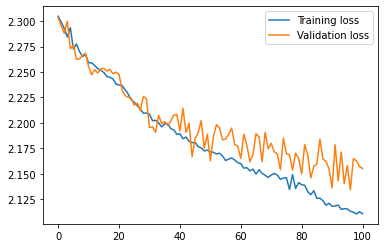

In [14]:
# plotting the training and validation loss
plt.plot(loss_list, label='Training loss')
plt.plot(loss_val_list, label='Validation loss')
plt.legend()
plt.show()

## Tensorboard
TensorBoard provides visualization and tooling for machine learning experimentation:
- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data
- Profiling programs

Tensorboard worked originally with Tensorflow but can now be used with PyTorch as well.  
You can embed a tensorboard widget in a Jupyter Notebook, although if you're not using Google Colab we recommend that you open tensorboard separately.

To get started with Tensorboard, please read the following pages:

PyTorch related:
1. https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
1. https://becominghuman.ai/logging-in-tensorboard-with-pytorch-or-any-other-library-c549163dee9e
1. https://towardsdatascience.com/https-medium-com-dinber19-take-a-deeper-look-at-your-pytorch-model-with-the-new-tensorboard-built-in-513969cf6a72
1. https://pytorch.org/docs/stable/tensorboard.html
1. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/04-utils/tensorboard

Tensorflow related:
1. https://itnext.io/how-to-use-tensorboard-5d82f8654496
1. https://www.datacamp.com/community/tutorials/tensorboard-tutorial
1. https://medium.com/@anthony_sarkis/tensorboard-quick-start-in-5-minutes-e3ec69f673af
1. https://www.guru99.com/tensorboard-tutorial.html
1. https://www.youtube.com/watch?time_continue=1&v=s-lHP8v9qzY&feature=emb_logo
1. https://www.youtube.com/watch?v=pSexXMdruFM


### Starting Tensorboard
Jupyter Notebook has extensions for displaying TensorBoard inside the notebook. Still, I recommend that you run it separately, as it tends to get stuck in notebooks.

The syntax to load TensorBoard in a notebook is this:
```python
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir ./logs
```

In the shell, you can instead run:
```
tensorboard --logdir ./logs
```

In [64]:
%load_ext tensorboard
%tensorboard --logdir ./runs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7944), started 1 day, 3:20:25 ago. (Use '!kill 7944' to kill it.)

### Show images using TensorBoard

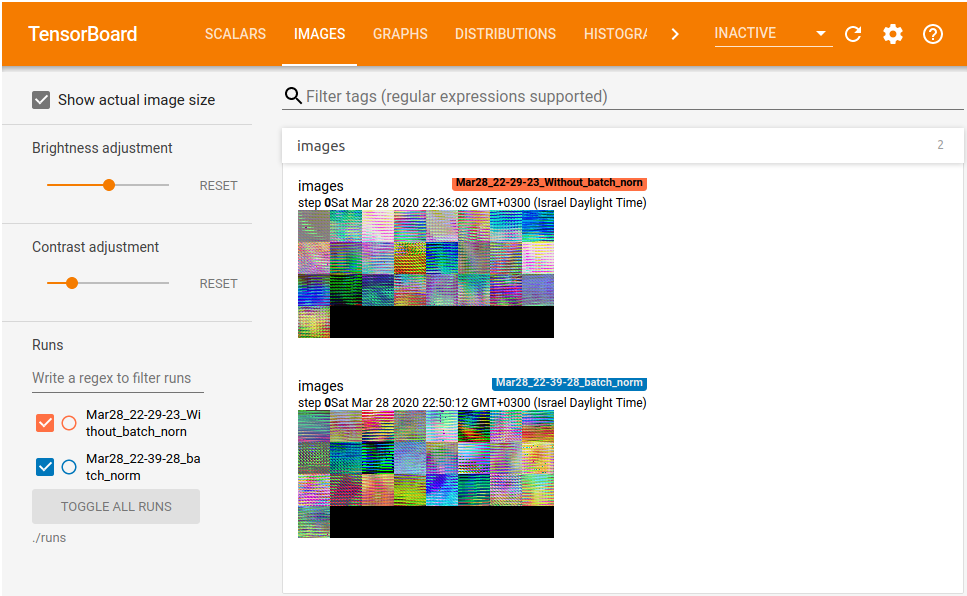

### Inspect the model graph
You can print a network object to find useful information about it:

In [17]:
print(model_without_batchnorm)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 24, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


TensorBoard can help visualize the network graph. It takes practice to read these.  

Write the graph to TensorBoard and review it.

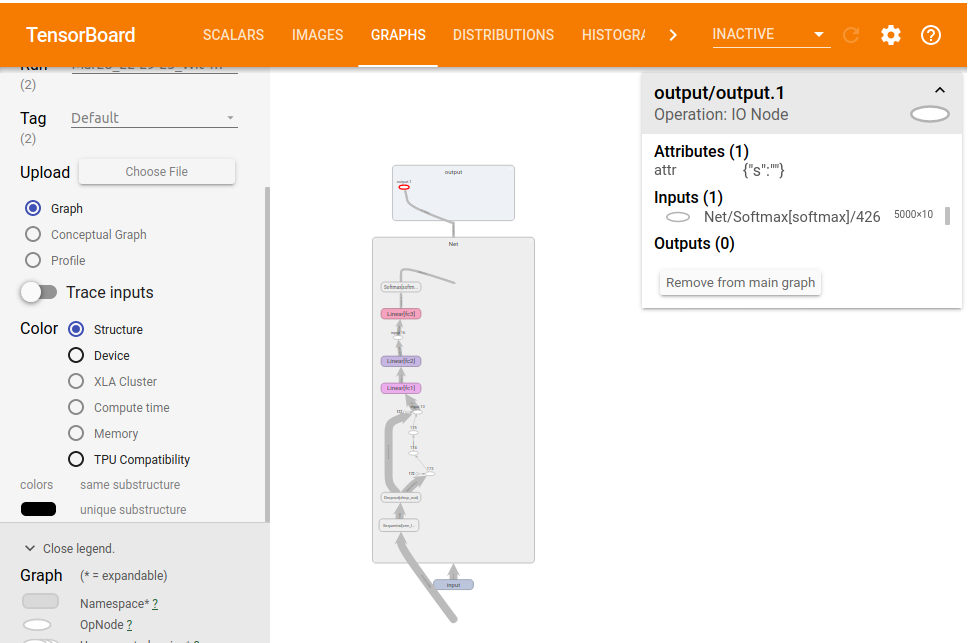

You can also use the package `torchsummary` for a fuller info on the model:

In [19]:
channels=3; H=32; W=32
from torchsummary import summary
summary(model_without_batchnorm, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
              ReLU-2            [-1, 6, 30, 30]               0
         MaxPool2d-3            [-1, 6, 15, 15]               0
            Conv2d-4           [-1, 24, 11, 11]           3,624
              ReLU-5           [-1, 24, 11, 11]               0
         MaxPool2d-6             [-1, 24, 5, 5]               0
            Conv2d-7             [-1, 64, 7, 7]          13,888
              ReLU-8             [-1, 64, 7, 7]               0
            Conv2d-9           [-1, 48, 11, 11]           3,120
             ReLU-10           [-1, 48, 11, 11]               0
        MaxPool2d-11             [-1, 48, 5, 5]               0
          Dropout-12             [-1, 48, 5, 5]               0
           Linear-13                  [-1, 120]         144,120
           Linear-14                   

## Train the network
Next, we'll train the network. In the training loop, log relevant metrics that would allow you to plot in TensorBoard:

1. The network loss
1. Train and test error
1. Average weight in the first layer
1. Histogram of weights in the first layer

#### Answer 
did while traing the model

### Precision-Recall Curve
Use TensorBoard to plot the precision-recall curve:

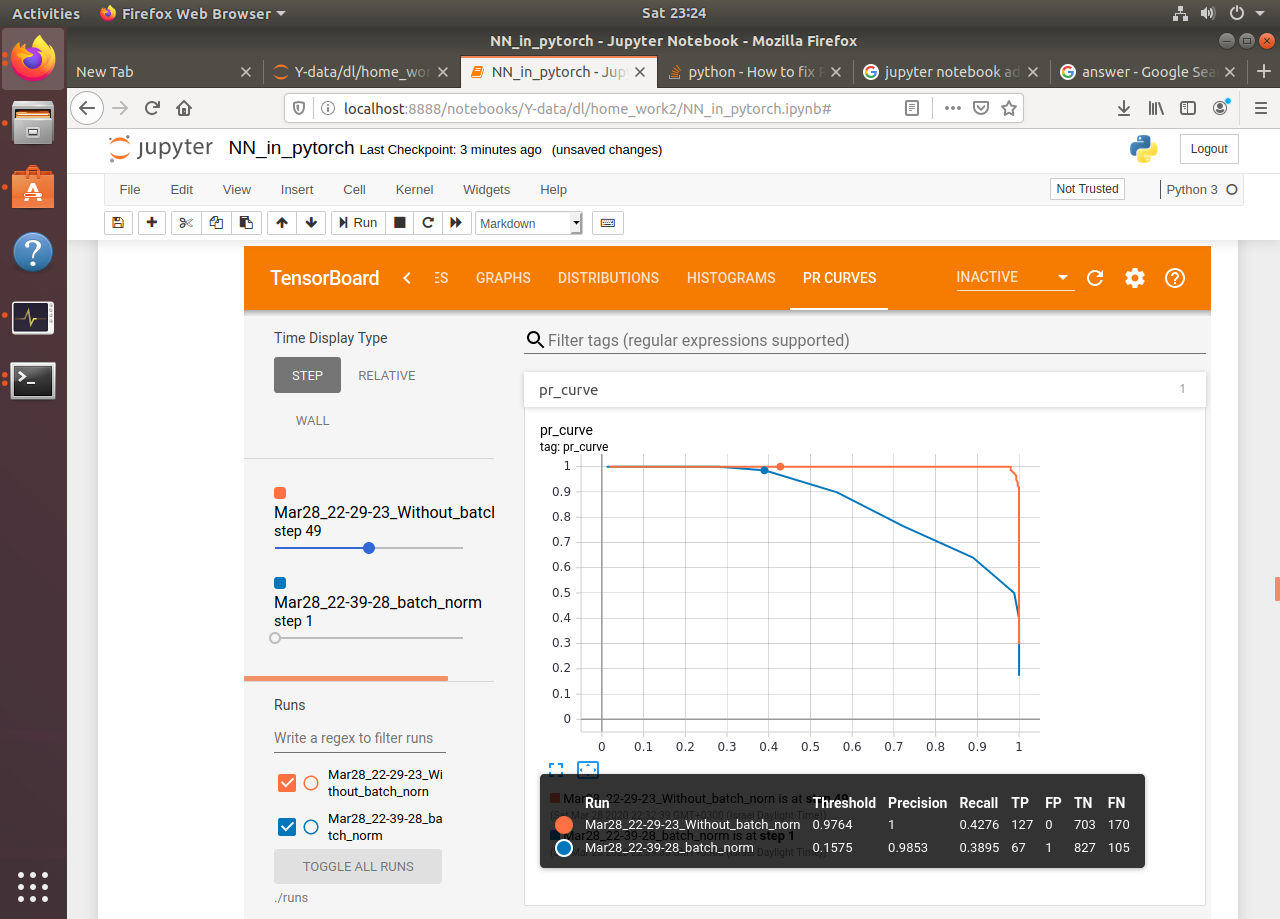

### Display Model Errors
A valuable practice is to review errors made by the model in the test set. These might reveal cases of bad preprocessing or lead to come up with improvements to your original model.

Show 12 images of errors made by the model. For each, display the true and predicted classes, and the model confidence in its answer.

In [28]:
validation_set_size = 1000
items_val = np.arange(val_x.shape[0])
items_val_index = np.random.choice(items_val, size=validation_set_size, replace=False)
outputs_val = model_with_batchnorm(val_x[items_val_index].float())
_, predicted_val = torch.max(outputs_val.data, 1)
error_items_filter = items_val_index[(predicted_val == val_y[items_val_index])]

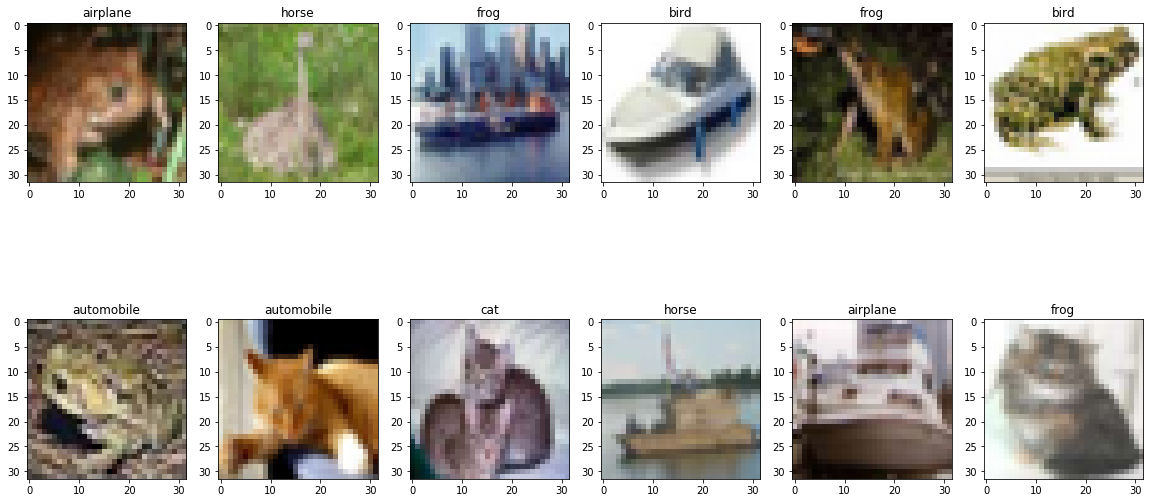

In [29]:
plt.figure(figsize=(20,10))
columns = 6
for i in range(12):
    plt.subplot(8 / columns + 1, columns, i + 1)
    plt.imshow(testset.data[error_items_filter[i]])
    plt.title(trainset.classes[trainset.targets[error_items_filter[i]]])
plt.show()

## Batch Normalization
In this section, we'll add a Batch Norm layer to your network.  
Use TensorBoard to compare the network's convergence (train and validation loss) with and without Batch Normalization.

In [30]:
class Net_BatchNorm(Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
        
        Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1)),
        BatchNorm2d(6),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        Conv2d(6, 24, kernel_size=(5, 5), stride=(1, 1)),
        BatchNorm2d(24),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1),padding=2),
        BatchNorm2d(64),    
        ReLU(inplace=True),
        Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1),padding=2),
        BatchNorm2d(64),
        ReLU(inplace=True),    
        MaxPool2d(kernel_size=2, stride=2),
        BatchNorm2d(48)
        )
        self.drop_out = Dropout()
        self.fc1 = Linear(in_features=1200, out_features=120, bias=True)
        self.fc2 = Linear(in_features=120, out_features=84, bias=True)
        self.fc3 = Linear(in_features=84, out_features=10, bias=True)
        self.softmax = Softmax(dim=1)

    # Defining the forward pass    
    def forward(self, input):
      
        output = self.cnn_layers(input)
        output = self.drop_out(output)
       
        output = output.view(output.size(0),  48* 5* 5)
       
        output = self.fc1(output)
        output = F.relu(self.fc2(output))
        output = self.softmax(self.fc3(output))
        return output

In [27]:
#call this model, and define the optimizer and the loss function for the model
# defining the model
model_with_batchnorm = Net()
# defining the optimizer (Adam optimizer)
optimizer = Adam(model_with_batchnorm.parameters(), lr=0.001)
# defining the loss function
criterion = CrossEntropyLoss()

print(model_with_batchnorm)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 24, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
loss_list, loss_val_list, acc_list = train(model_with_batchnorm,  100,  5000) 

 epoch [1/100],  Loss: 2.3036, Accuracy: 9.92%/0.10   precision:0.118 
 epoch [5/100],  Loss: 2.2694, Accuracy: 17.32%/0.17   precision:0.183 
 epoch [9/100],  Loss: 2.2442, Accuracy: 18.88%/0.19   precision:0.188 
 epoch [13/100],  Loss: 2.2258, Accuracy: 20.94%/0.21   precision:0.227 
 epoch [17/100],  Loss: 2.2127, Accuracy: 22.76%/0.23   precision:0.226 


Use TensorBoard to plot the distribution of activations with and without Batch Normalization.

In [23]:
%load_ext tensorboard
%tensorboard --logdir ./runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7944), started 1 day, 1:59:27 ago. (Use '!kill 7944' to kill it.)

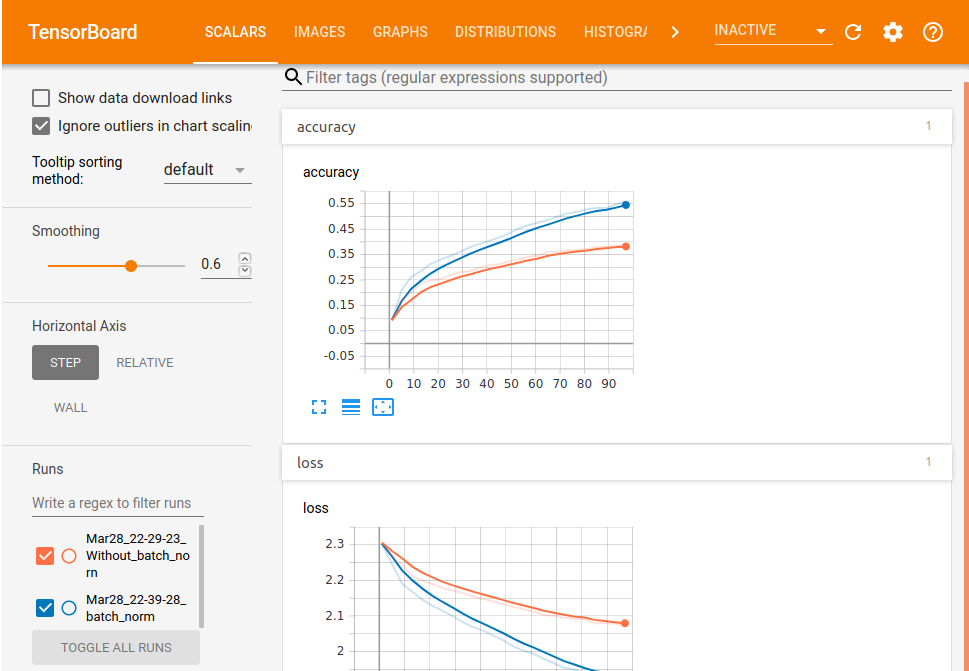

## Data Augmentation
Augmenting the data is a useful trick to increase the size of the training set and reduce the generalization error.  

Useful resources: 
- [Explanation about augmentation](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)
- The [torchvision transforms documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)
- The [albumentations](https://github.com/albumentations-team/albumentations) repo

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt

Try to think which transformation can be useful for data augmentation for our task?

#### Answer
In our case flipping transformation, adding noise/blurring to the images or rotate it could be useful for our task by providing more samples and make the system more robust.

Apply 1 or 2 basic transformations and check how they affect the network's performance:

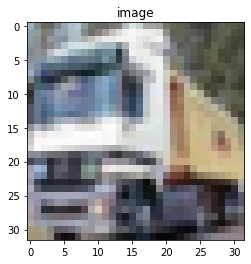

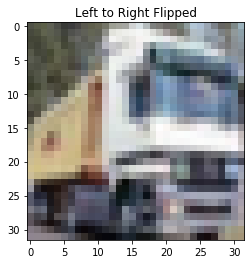

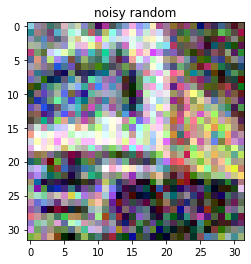

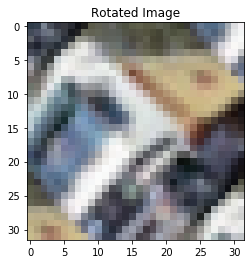

In [29]:
from skimage.transform import rotate
from skimage.util import random_noise

flipLR = np.fliplr(trainset.data[1])
plt.title('image')
plt.imshow(trainset.data[1])
plt.show()
plt.imshow(flipLR)
plt.title('Left to Right Flipped')
plt.show()

sigma=0.155
#add random noise to the image
noisyRandom = random_noise(trainset.data[1],var=sigma**2)
plt.imshow(noisyRandom)
plt.title('noisy random')
plt.show()

#rotating the image by 45 degrees
rotated = rotate(trainset.data[1], angle=45, mode = 'wrap')
#plot the rotated image
plt.imshow(rotated)
plt.title('Rotated Image')
plt.show()

## Transfer learning using a NN pre-trained on ImageNet
In this section, we will use a pretrained network and build a classifier using it to predict the labels of our task.

You might find these resources useful:
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
- https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/
- https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72

### Use a frozen pre-trained network
Use a VGG-16 network, including its weights pretrained on ImageNet.  
Use the pretrained network to obtain the distributed representation in the final layer (the one before the output softmax layer). Freeze the network weights, and add 2 fully connected layers on top of it to classify the images.

In [165]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

In [166]:
# Freeze model weights
for param in vgg16.parameters():
    param.requires_grad = False

In [167]:
import torch.nn as nn
# Add on classifier
n_inputs = 4096
n_classes = 10

vgg16.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

In [188]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [168]:
from torch import optim
# Loss and optimizer
criteration = nn.NLLLoss()
optimizer = optim.Adam(vgg16.parameters())

In [184]:
# Early stopping details
n_epochs = 5
batch_size = 10000
items = np.arange(train_x.shape[0])
items_index = np.random.choice(items, size=batch_size , replace=False)

# n_epochs_stop = 5
min_val_loss = np.Inf
epochs_no_improve = 0

# Main loop
for epoch in range(n_epochs):
    print(f"epoch:{epoch}")
  # Initialize validation loss for epoch
    val_loss = 0
  
    # Training loop
    for data, targets in trainloader:
#         print(data.shape)
        # Generate predictions
        out = vgg16(data[items_index])
        # Calculate loss
        loss = criterion(out, targets[items_index])
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
    
# Validation loop
for data, targets in testloader:
    # Generate predictions 
    out = vgg16(data)
    # Calculate loss
    loss = criterion(out, targets)
    val_loss += loss

# Average validation loss
val_loss = val_loss / len(trainloader)
print(f"val_loss:{val_loss}")

epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
val_loss:11000.4091796875


In [186]:
outputs_val = vgg16(val_x.float())

loss_val = criterion(outputs_val, val_y)
_, predicted_val = torch.max(outputs_val.data, 1)
correct_val = (predicted_val == val_y).sum().item()
print(correct_val)
# loss_val_list.append(loss_val.item())

1049


In [187]:
val_x.shape

torch.Size([10000, 3, 32, 32])

### Fine tuning the weights
In this section, we'll unfreeze the pre-trained weights of the network and allow them to change.  
Be careful - when fine-tuning a network, there is a risk that our attempt to allow the network to adapt to the new domain will lead to a "catastrophic forgetting" of what it had previously learnt.

In [189]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

In [190]:
n_inputs = 4096
n_classes = 10

vgg16.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

In [191]:
# Early stopping details
n_epochs = 2
batch_size = 10000
items = np.arange(train_x.shape[0])
items_index = np.random.choice(items, size=batch_size , replace=False)

# n_epochs_stop = 5
min_val_loss = np.Inf
epochs_no_improve = 0

# Main loop
for epoch in range(n_epochs):
    print(f"epoch:{epoch}")
  # Initialize validation loss for epoch
    val_loss = 0
  
    # Training loop
    for data, targets in trainloader:
#         print(data.shape)
        # Generate predictions
        out = vgg16(data[items_index])
        # Calculate loss
        loss = criterion(out, targets[items_index])
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
    
# Validation loop
for data, targets in testloader:
    # Generate predictions 
    out = vgg16(data)
    # Calculate loss
    loss = criterion(out, targets)
    val_loss += loss

# Average validation loss
val_loss = val_loss / len(trainloader)
print(f"val_loss:{val_loss}")

epoch:0
epoch:1
val_loss:6038.39013671875


In [192]:
outputs_val = vgg16(val_x.float())

loss_val = criterion(outputs_val, val_y)
_, predicted_val = torch.max(outputs_val.data, 1)
correct_val = (predicted_val == val_y).sum().item()
print(correct_val)
# loss_val_list.append(loss_val.item())

1044


## Suggested Resources
1. A good explanation of the different losses - https://gombru.github.io/2019/04/03/ranking_loss/
1. A repo with code implementing CNN classifiers, Siamese networks and Triplet loss with different selection regimes for the MNIST and Fashion-MNIST datasets - https://github.com/adambielski/siamese-triplet
1. There are several resources online for the VGG-Face network (see https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf), that include pre-trained weights on a face recognition dataset. The weights are here - http://www.robots.ox.ac.uk/~vgg/software/vgg_face/, and PyTorch models are here - http://www.robots.ox.ac.uk/~albanie/pytorch-models.html, and you can also check out https://github.com/prlz77/vgg-face.pytorch and https://github.com/claudio-unipv/vggface-pytorch.